## Foreground-Background Separation using ADMM and RPCA

This notebook performs **Robust Principal Component Analysis (RPCA)** to separate background (low-rank)
and foreground (sparse) elements from a sequence of video frames. The optimization is solved using
**Alternating Direction Method of Multipliers (ADMM)**.

Applications include:
- Background subtraction
- Motion detection
- Anomaly tracking in videos

In [84]:
import numpy as np
import matplotlib.pyplot as plt

### Utility Functions
- `soft_threshold`: Element-wise soft thresholding (L1 proximal operator)
- `prox_t_nuclear_norm`: Applies singular value thresholding (nuclear norm proximal operator)
- `display_frame`: Plots a reshaped image from a column of a matrix

In [85]:

def soft_threshold(Z, lamb):
    return np.sign(Z) * np.maximum(np.abs(Z) - (1 / rho), 0)
    


def prox_t_nuclear_norm(X: np.ndarray, t: float):
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    d = np.maximum(s - t, 0)
    return (U * d) @ Vt

def display_frame(matrix, frame_index, title, image_shape = (224, 304)):
        img = matrix[:, frame_index].reshape(image_shape)  #original image dimensions
        frame = np.clip(img, 0, 255).astype(np.uint8)
        plt.imshow(frame, cmap='gray')
        plt.title(title)
        plt.axis('off')

### Image Loading and Rescaling

- `rescale_images`: Loads image files from a folder and converts them into columns of a matrix `A`
- Each column corresponds to a flattened grayscale image
- This matrix is used as the input to the RPCA algorithm

In [86]:
from PIL import Image
import os


def rescale_images(dataset_folder_path, num_imgs=None):

    image_list = []
    image_array_list = []
    img_paths = []

    for filename in os.listdir(dataset_folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):  # possible file extensions
            image_path = os.path.join(dataset_folder_path, filename)
            img = Image.open(image_path)  # load image
            img_array = np.array(img).flatten() # numpy array
            image_list.append(img)  # append image to list
            image_array_list.append(img_array) # append np.array to list
            img_paths.append(image_path)
    
    print(f"Loaded {len(image_list)} images.")
    if num_imgs:
        assert(num_imgs == len(image_list))
    matrix = np.column_stack(image_array_list)  # create matrix where each column is an image
    A_rescaled = matrix.astype(np.float64)
    print(f"Rescaled images to shape: {A_rescaled.shape}")
    print(f"Range of A: [{min(0, A_rescaled.min())}, {max(255,A_rescaled.max())}]")
    return A_rescaled


### ADMM Implementation for RPCA

- `admm_rank_sparsity`: Solves
  \[ \min_{L, M} \|L\|_1 + \gamma \|M\|_* \quad \text{s.t.} \quad A = L + M \]
- Uses soft-thresholding for sparse foreground `L`
- Uses singular value thresholding for low-rank background `M`
- Converges when both primal and dual residuals are below their thresholds

In [90]:
def admm_rank_sparsity(A, gamma, rho, maxit, primtol, dualtol):

    """
    Args:
    A : input L + M (L = sparse but high rank: foreground, M = dense but low rank: background)
    gamma : weight of nuclear norm term (||M||*)
    rho: weight on penalty term
    primtol: tolerance for primal residual  ||Lk + Mk - A||_F
    dualtol: tolerance for dual residual


    convergence: ||Lk +Mk −A||_F < primtol and rho * ||Mk - Mk-1||_F < dualtol


    
    """
    L = np.zeros_like(A) # foreground
    M = np.zeros_like(A) # background
    Y = np.zeros_like(A) # Lagrangian dual variable
    numit = 1

    while numit <= maxit:

        # Loss = np.sum(np.sum(np.abs(L), axis=0), axis=1) + gamma * prox_t_nuclear_norm(M) + Y.T(L+M-A) + (rho/2) * np.linalg.norm(L+M-A)**2
        # L_new = argmin_L(Loss)
        # M_new = argmin_M(Loss)

        try:
            
            Z = A - M - Y/rho

            # proximal operator of the L1 norm = soft thresholding
            L_new = np.sign(Z) * np.maximum(np.abs(Z) - (1 / rho), 0)
            

            X = A - L_new - Y/rho
            U, s, Vt = np.linalg.svd(X, full_matrices=False)
            d = np.maximum(s - gamma/rho, 0)
            M_new = (U * d) @ Vt

            # Solve Using Proximal Operator for Nuclear Norm
            # M_new = prox_t_nuclear_norm(X, gamma/rho)
  
            Y_new = Y + rho * (L_new + M_new - A)

            prim_res = np.linalg.norm((L_new + M_new - A), ord="fro")
            dual_res = rho * (np.linalg.norm((M_new - M), ord="fro"))

            L = L_new
            M = M_new
            Y = Y_new
            if prim_res < primtol and dual_res < dualtol:
                break
            if numit % 100 == 0:
                print(numit)
            numit+=1
        except Exception as e:
            print(f"ERROR in iteration: {numit}")
            print(e)
            break

    return L, M, Y, numit



    

### Driver Function and Visualization

- `admm_driver`: Runs RPCA on a folder of images and displays results
- Decomposes image matrix into sparse foreground and low-rank background
- Shows a few example frames side-by-side for qualitative evaluation

In [91]:
def admm_driver(data_path,gamma, rho, primtol, dualtol, maxit):

    A = rescale_images(data_path)

    L, M, Y, numit = admm_rank_sparsity(A, gamma, rho, maxit, primtol, dualtol)
    print(f"converged in iterations: {numit}")
    
    seq = [4*i for i in range(8)]
    for idx in seq:

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        display_frame(M, idx, f"Low-Rank (Background) - Frame {idx + 1}")
        plt.subplot(1, 2, 2)
        display_frame(L, idx, f"Sparse (Foreground) - Frame {idx + 1}")
        plt.show()
        

### Run the Decomposition

- Load images from the `bottle_dataset` folder
- Run ADMM with specified hyperparameters
- Show 8 selected frames to observe separation

Loaded 31 images.
Rescaled images to shape: (68096, 31)
Range of A: [0, 255]
100
200
300
converged in iterations: 384


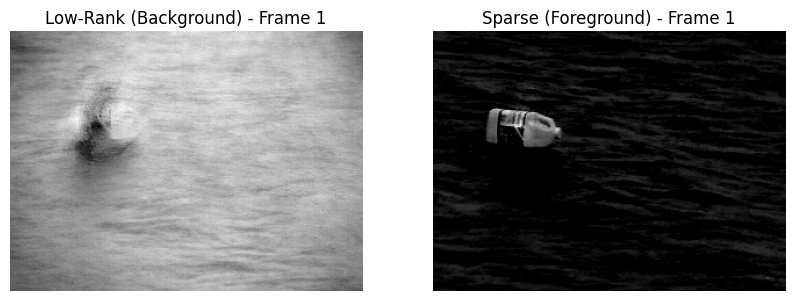

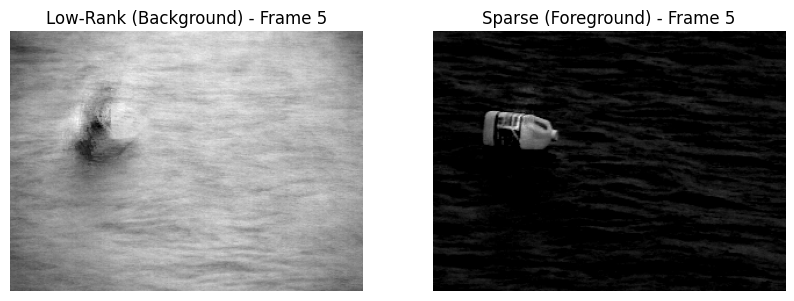

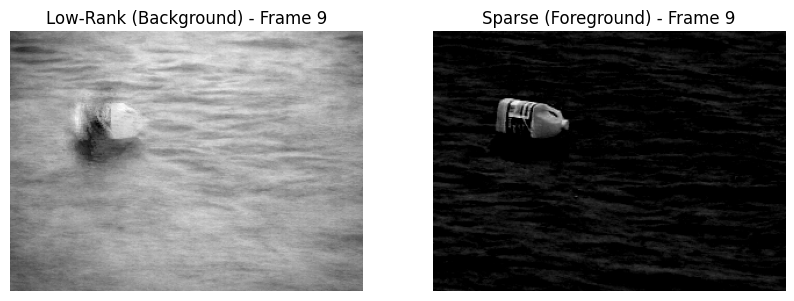

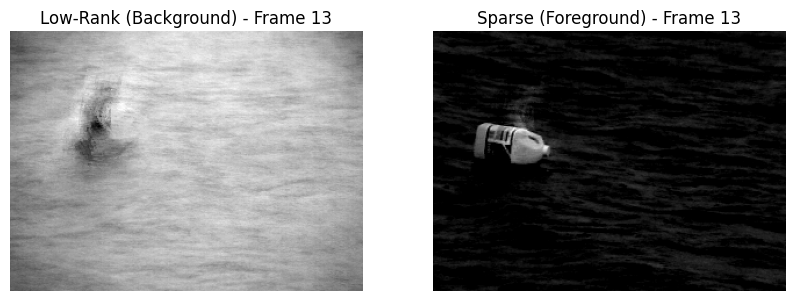

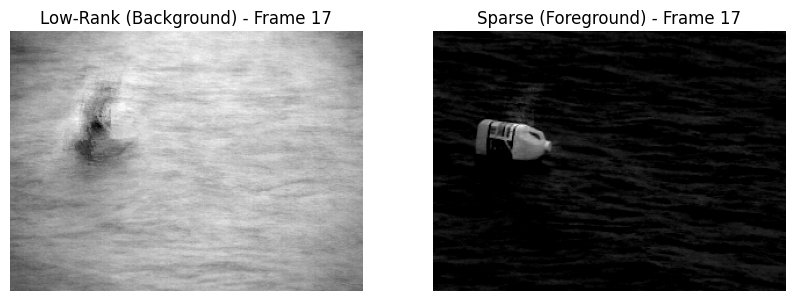

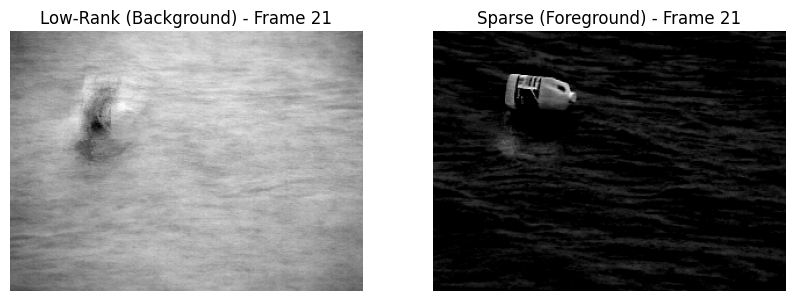

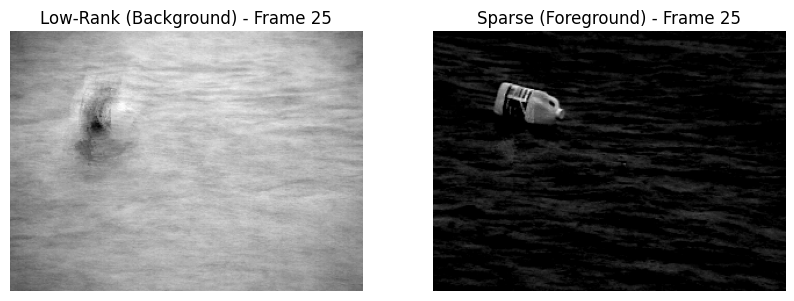

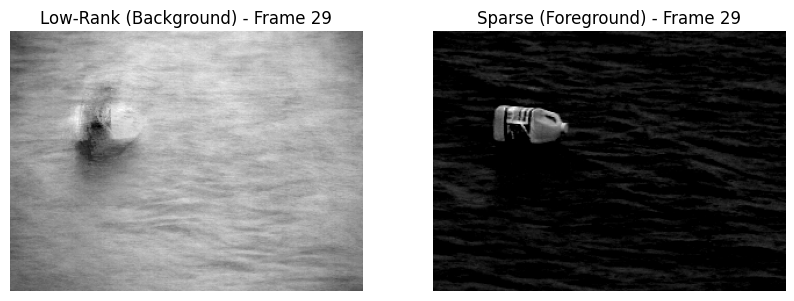

In [92]:

# Folder containing images
folder_path = "bottle_dataset"
admm_driver(folder_path, gamma=300, rho=0.3, primtol=0.1, dualtol=0.1, maxit=20000)